<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_07_Segmentation_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 День 7: Введение в сегментацию


## 🧠 Теория: Что такое сегментация?
- **Сегментация** — это задача присвоения метки каждому пикселю изображения.
- В отличие от детекции, где мы ограничиваем объект рамкой, здесь мы точно выделяем форму объекта.
- Типы сегментации:
  - *Semantic segmentation*: все объекты одного класса объединяются (например, все машины).
  - *Instance segmentation*: различаются отдельные экземпляры (машина 1, машина 2).
  - *Panoptic segmentation*: объединяет semantic + instance.


## 🧪 Пример применения: Semantic Segmentation
Semantic сегментация может использоваться в медицине (выделение органов), авто (распознавание дороги, пешеходов), и т.д.

## 🔧 Практика: Маскирование по цвету
Попробуем выделить красные объекты на изображении с помощью OpenCV:


In [12]:
# Импорт библиотек
import cv2
import numpy as np
import matplotlib.pyplot as plt

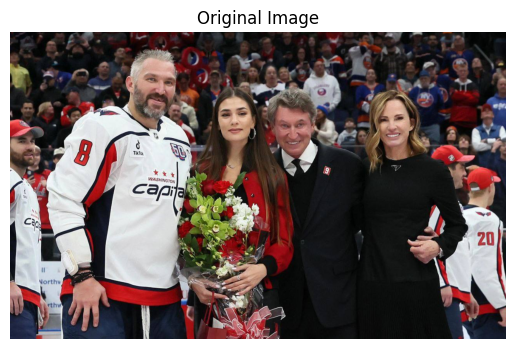

In [13]:
# Загрузка и отображение изображения
image = cv2.imread('Foto_Ovechkin.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

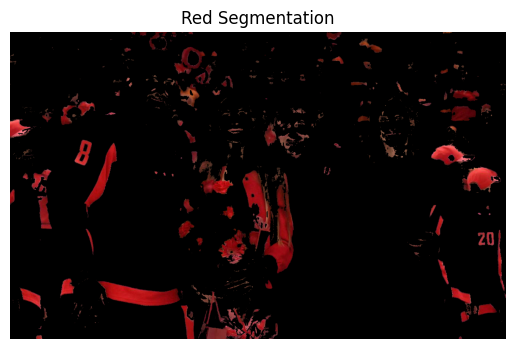

In [14]:
# Маскирование по красному цвету
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_red = np.array([0, 120, 70])
upper_red = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)

lower_red = np.array([170, 120, 70])
upper_red = np.array([180, 255, 255])
mask2 = cv2.inRange(hsv, lower_red, upper_red)

mask = mask1 + mask2
result = cv2.bitwise_and(image, image, mask=mask)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Red Segmentation')
plt.axis('off')
plt.show()

## 🧮 Линейная алгебра: Комбинация трансформаций
Создадим матрицы для поворота и масштабирования, и применим их в разном порядке.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Матрица поворота на 45 градусов
angle = np.radians(45)
cos, sin = np.cos(angle), np.sin(angle)
R = np.array([[cos, -sin], [sin, cos]])

# Матрица масштабирования
S = np.array([[1.5, 0], [0, 1.5]])

# Применим R потом S
RS = S @ R
print('S * R =')
print(RS)

# Применим S потом R
SR = R @ S
print('R * S =')
print(SR)

S * R =
[[ 1.06066017 -1.06066017]
 [ 1.06066017  1.06066017]]
R * S =
[[ 1.06066017 -1.06066017]
 [ 1.06066017  1.06066017]]


## 🧠 U-Net: базовая модель сегментации
**U-Net** — это сверточная нейронная сеть, разработанная для биомедицинской сегментации. Её структура напоминает букву «U».
- Архитектура состоит из двух частей: **энкодер** (снижение размерности) и **декодер** (восстановление разрешения).
- Используются **скип-соединения** между слоями энкодера и декодера, чтобы сохранить пространственную информацию.

### Архитектура
```
Input → [Conv → ReLU → Conv → ReLU] → MaxPool → ... → Bottleneck →
Upsample → [Conv → ReLU → Conv → ReLU] + Skip → ... → Output mask
```


### 🧮 Loss-функции в U-Net
- **Binary Cross Entropy (BCE)** — для бинарной сегментации.
- **Dice Loss** — более устойчива к дисбалансу классов:
$$ \mathcal{L}_{dice} = 1 - \frac{2 \cdot |P \cap G|}{|P| + |G|} $$
- **BCE + Dice** — часто комбинируются для лучших результатов.


### 🔁 Модификации U-Net
- **U-Net++** — использует плотные скип-соединения и nested архитектуру.
- **Attention U-Net** — добавляет механизмы внимания, чтобы модель фокусировалась на важном контексте.
- **ResUNet** — использует остаточные блоки из ResNet.


## 🔧 PyTorch: Реализация U-Net
Ниже — базовая реализация U-Net для бинарной сегментации.

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = self.conv_block(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.decoder2(torch.cat([self.upconv2(b), e2], dim=1))
        d1 = self.decoder1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

Эта модель как основа и обучать модель на своих изображениях с масками.


## 📌 Классификация, сегментация на красный цвет (Random Forest)



{'0': {'precision': 1.0, 'recall': 0.999718785151856, 'f1-score': 0.9998593728027001, 'support': 17780.0}, '1': {'precision': 0.9973488865323435, 'recall': 1.0, 'f1-score': 0.9986726838332891, 'support': 1881.0}, 'accuracy': 0.9997456894359392, 'macro avg': {'precision': 0.9986744432661718, 'recall': 0.999859392575928, 'f1-score': 0.9992660283179946, 'support': 19661.0}, 'weighted avg': {'precision': 0.9997463636421005, 'recall': 0.9997456894359392, 'f1-score': 0.9997458403297097, 'support': 19661.0}}


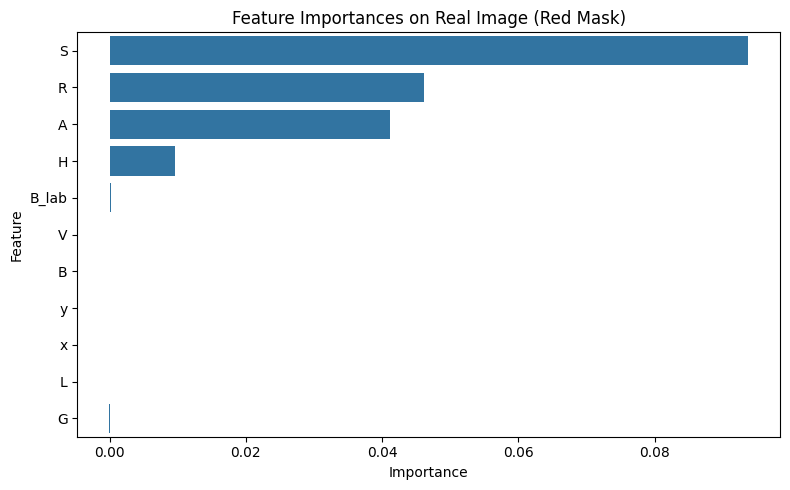

,Feature,Importance
4,S,0.093739
0,R,0.046183
7,A,0.041198
3,H,0.009582
8,B_lab,0.000173
5,V,0.000092
2,B,0.000020
10,y,0.000000
9,x,0.000000
6,L,-0.000031


In [16]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

# Загружаем изображение
img_path = "/content/Foto_Ovechkin.jpg"
image = cv2.imread(img_path)
image = cv2.resize(image, (256, 256))  # Уменьшаем размер для скорости
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

# Создаем маску по красному цвету
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = mask1 + mask2

# Сбор признаков
features = []
labels = []

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        b, g, r = image[y, x]
        h, s, v = hsv[y, x]
        l, a, b_lab = lab[y, x]
        x_norm = x / image.shape[1]
        y_norm = y / image.shape[0]
        features.append([r, g, b, h, s, v, l, a, b_lab, x_norm, y_norm])
        labels.append(mask[y, x] // 255)

X = np.array(features)
y = np.array(labels)

# Обучение
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(report)

# Важность признаков
perm = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
feature_names = ["R", "G", "B", "H", "S", "V", "L", "A", "B_lab", "x", "y"]
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm.importances_mean
}).sort_values(by="Importance", ascending=False)

# Построение графика
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importances_df)
plt.title("Feature Importances on Real Image (Red Mask)")
plt.tight_layout()
plt.show()

importances_df.head(10)


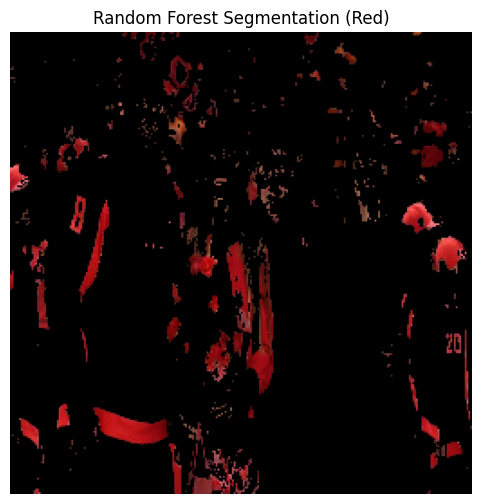

In [17]:
# Предсказания модели на всём изображении
y_pred_full = clf.predict(X).reshape((256, 256))

# Преобразуем в маску 0/255
rf_mask = (y_pred_full * 255).astype(np.uint8)

# Применим маску к изображению (как делали с HSV)
segmented = cv2.bitwise_and(image, image, mask=rf_mask)

# Покажем результат
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title('Random Forest Segmentation (Red)')
plt.axis('off')
plt.show()
